In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Variables
COLORS = sns.color_palette('pastel')
DPI = 300
BBOX = 'tight'

In [3]:
df_clean = pd.read_csv("data/listings_cleaned.csv.gz", index_col=0, compression="gzip", parse_dates=['host_since', 'first_review', 'last_review'])
df_og = pd.read_csv("data/listings.csv.gz", index_col=0, compression="gzip")
og_price = df_og['price'].str.replace('$', '').str.replace(',', '').astype(float)

---

## Comparison Between Original and Cleaned Data

Comparison between data types of the two datasets

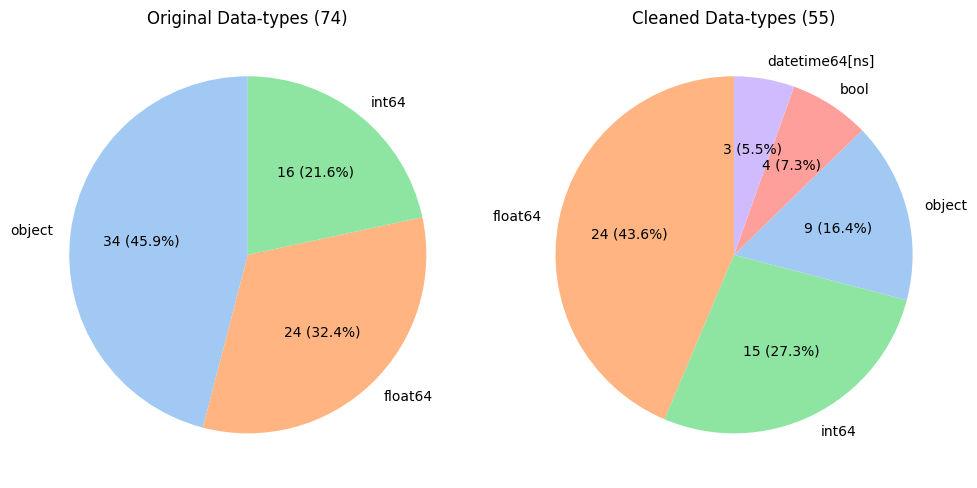

In [4]:
# Create color mappings for the dtypes
o_counts = df_og.dtypes.value_counts()
c_counts = df_clean.dtypes.value_counts()

all_dtypes = pd.concat([o_counts, c_counts], axis=1).fillna(0).set_axis(['Original', 'Cleaned'], axis=1)
color_map = {dtype: color for dtype, color in zip(all_dtypes.index, COLORS[:len(all_dtypes)])}

# Function to show both the percentage and the count of each data type
def count_and_pct(pct, data: pd.DataFrame):
    return f"{round(len(data.columns) * pct / 100)} ({pct:.1f}%)"

# Plot the pie charts
plt.figure(figsize=(10, 6))

# Original Dataset
plt.subplot(1,2,1)
plt.pie(o_counts, labels=o_counts.index.astype(str), autopct=lambda pct: count_and_pct(pct, df_og), colors=[color_map[d] for d in o_counts.index], startangle=90)
plt.title(f'Original Data-types ({len(df_og.columns)})')

# Cleaned Dataset
plt.subplot(1,2,2)
plt.pie(c_counts, labels=c_counts.index.astype(str), autopct=lambda pct: count_and_pct(pct, df_clean), colors=[color_map[d] for d in c_counts.index], startangle=90)
plt.title(f'Cleaned Data-types ({len(df_clean.columns)})')

plt.tight_layout()
plt.savefig('figures/analysis/data_types.png', dpi=DPI, bbox_inches=BBOX)
plt.show();

Comparison between the distributions of the prices of the listings in the cleaned dataset and the original dataset.

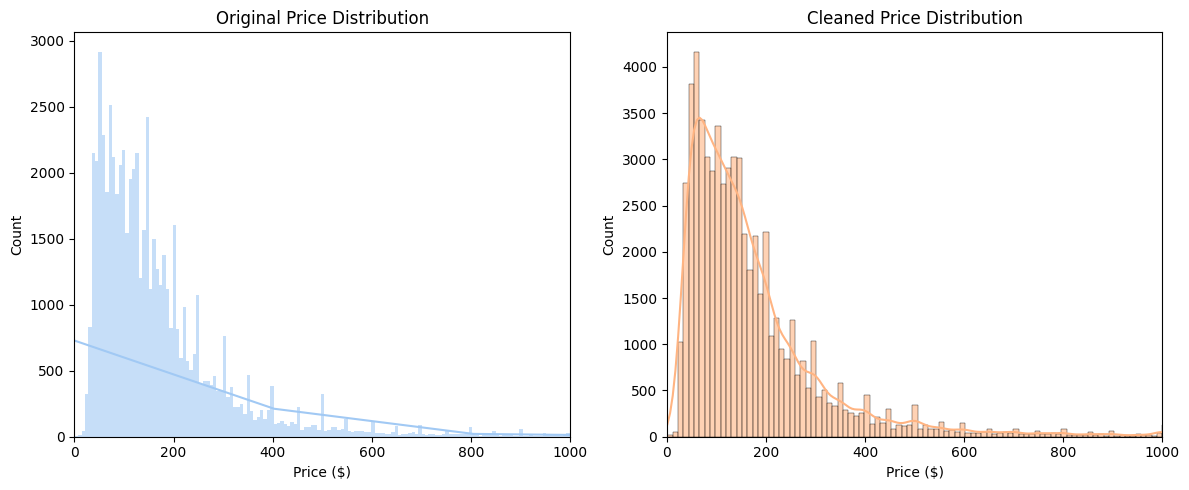

In [5]:
plt.figure(figsize=(12,5))

# Original Data
plt.subplot(1,2,1)
sns.histplot(og_price, bins='auto', kde=True, color=COLORS[0], alpha=0.6)
plt.title("Original Price Distribution")
plt.xlabel("Price ($)")
plt.xlim(0, 1000)

# Cleaned Data
plt.subplot(1,2,2)
sns.histplot(df_clean['price'], bins=100, kde=True, color=COLORS[1], alpha=0.6)
plt.title("Cleaned Price Distribution")
plt.xlabel("Price ($)")
plt.xlim(0, 1000)

plt.tight_layout()
plt.savefig("figures/analysis/price_distribution.png", dpi=DPI, bbox_inches=BBOX)
plt.show();

Outlier Detection before and after cleaning, through boxplot visualization

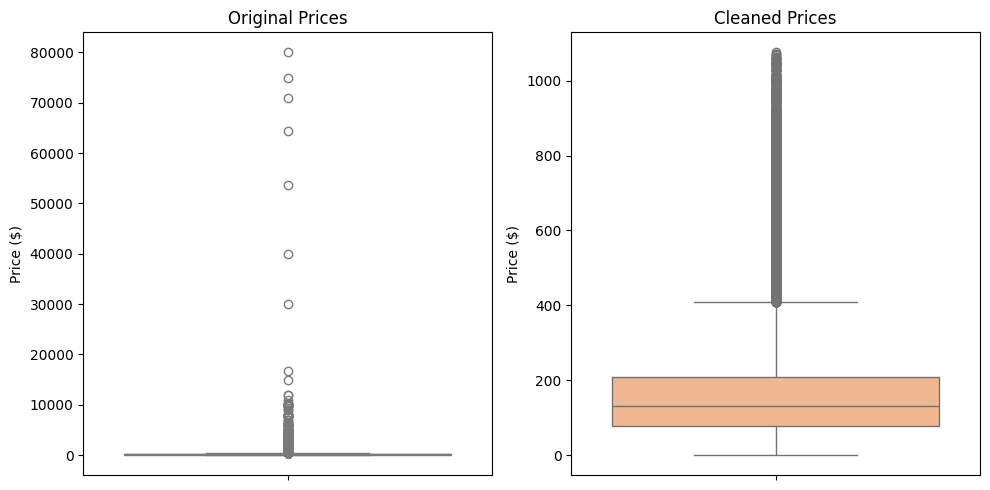

In [6]:
plt.figure(figsize=(10,5))

# Original Data
plt.subplot(1,2,1)
sns.boxplot(y=og_price, color=COLORS[0])
plt.title('Original Prices')
plt.ylabel('Price ($)')

# Cleaned Data
plt.subplot(1,2,2)
sns.boxplot(y=df_clean['price'], color=COLORS[1])
plt.title('Cleaned Prices')
plt.ylabel('Price ($)')

plt.tight_layout()
plt.savefig('figures/analysis/boxplot_prices.png', dpi=DPI, bbox_inches=BBOX)
plt.show();

---

## Visualizations of the Cleaned Data

Create a feature correlation heatmap to visualize the relationships between the features.

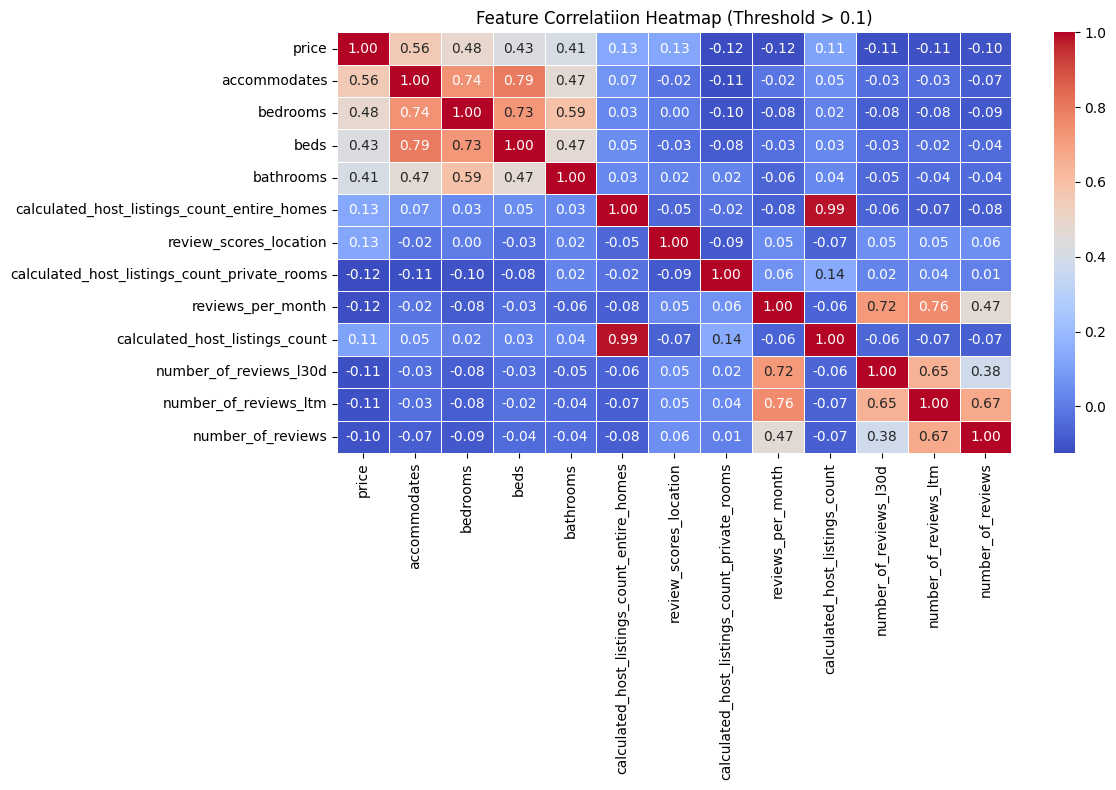

In [8]:
# Set a threshold of 0.1 correlation score for feature selection
corr_matrix = df_clean.select_dtypes(include=['number']).corr()
sorted_features = corr_matrix['price'].abs().sort_values(ascending=False)
selected_features = sorted_features[sorted_features > 0.1].index

# Plot the heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_clean[selected_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlatiion Heatmap (Threshold > 0.1)")

plt.tight_layout()
plt.savefig("figures/analysis/feature_correlation_heatmap.png", dpi=DPI, bbox_inches=BBOX)
plt.show();

Plot the distribution of the room types and neighborhoods against the price through boxplots.

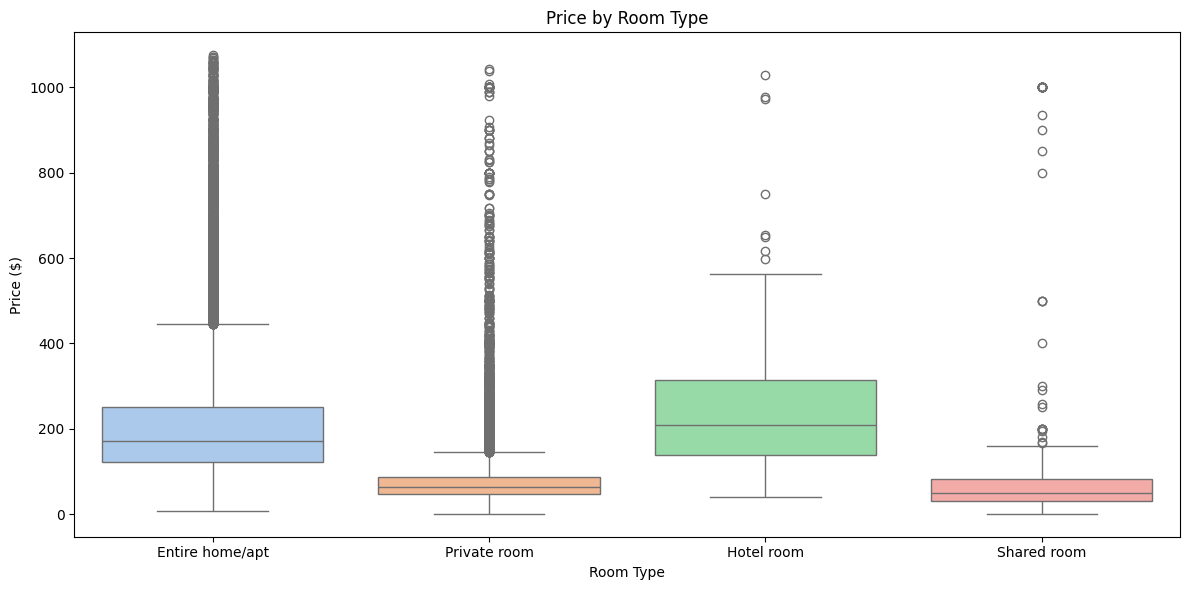

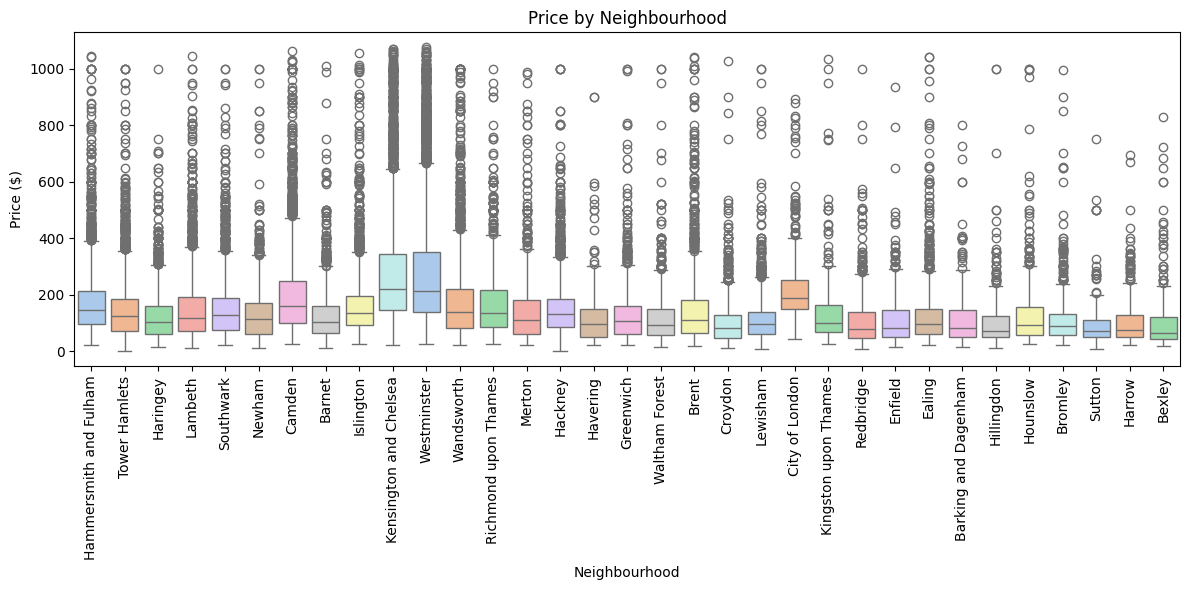

In [9]:
# Price by room type
plt.figure(figsize=(12,6))
sns.boxplot(x='room_type', y='price', data=df_clean, palette=COLORS)
plt.title('Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price ($)')

plt.tight_layout()
plt.savefig('figures/analysis/price_by_room_type.png', dpi=DPI, bbox_inches=BBOX)
plt.show();

# Price by neighbourhood
plt.figure(figsize=(12,6))
sns.boxplot(x='neighbourhood_cleansed', y='price', data=df_clean, palette=COLORS)
plt.title('Price by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Price ($)')
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig('figures/analysis/price_by_neighbourhood.png', dpi=DPI, bbox_inches=BBOX)
plt.show();

Plot the correlation matrix for the numerical features with the highest correlation to the price. Color code the scatter plots by the room type.

<Figure size 1000x800 with 0 Axes>

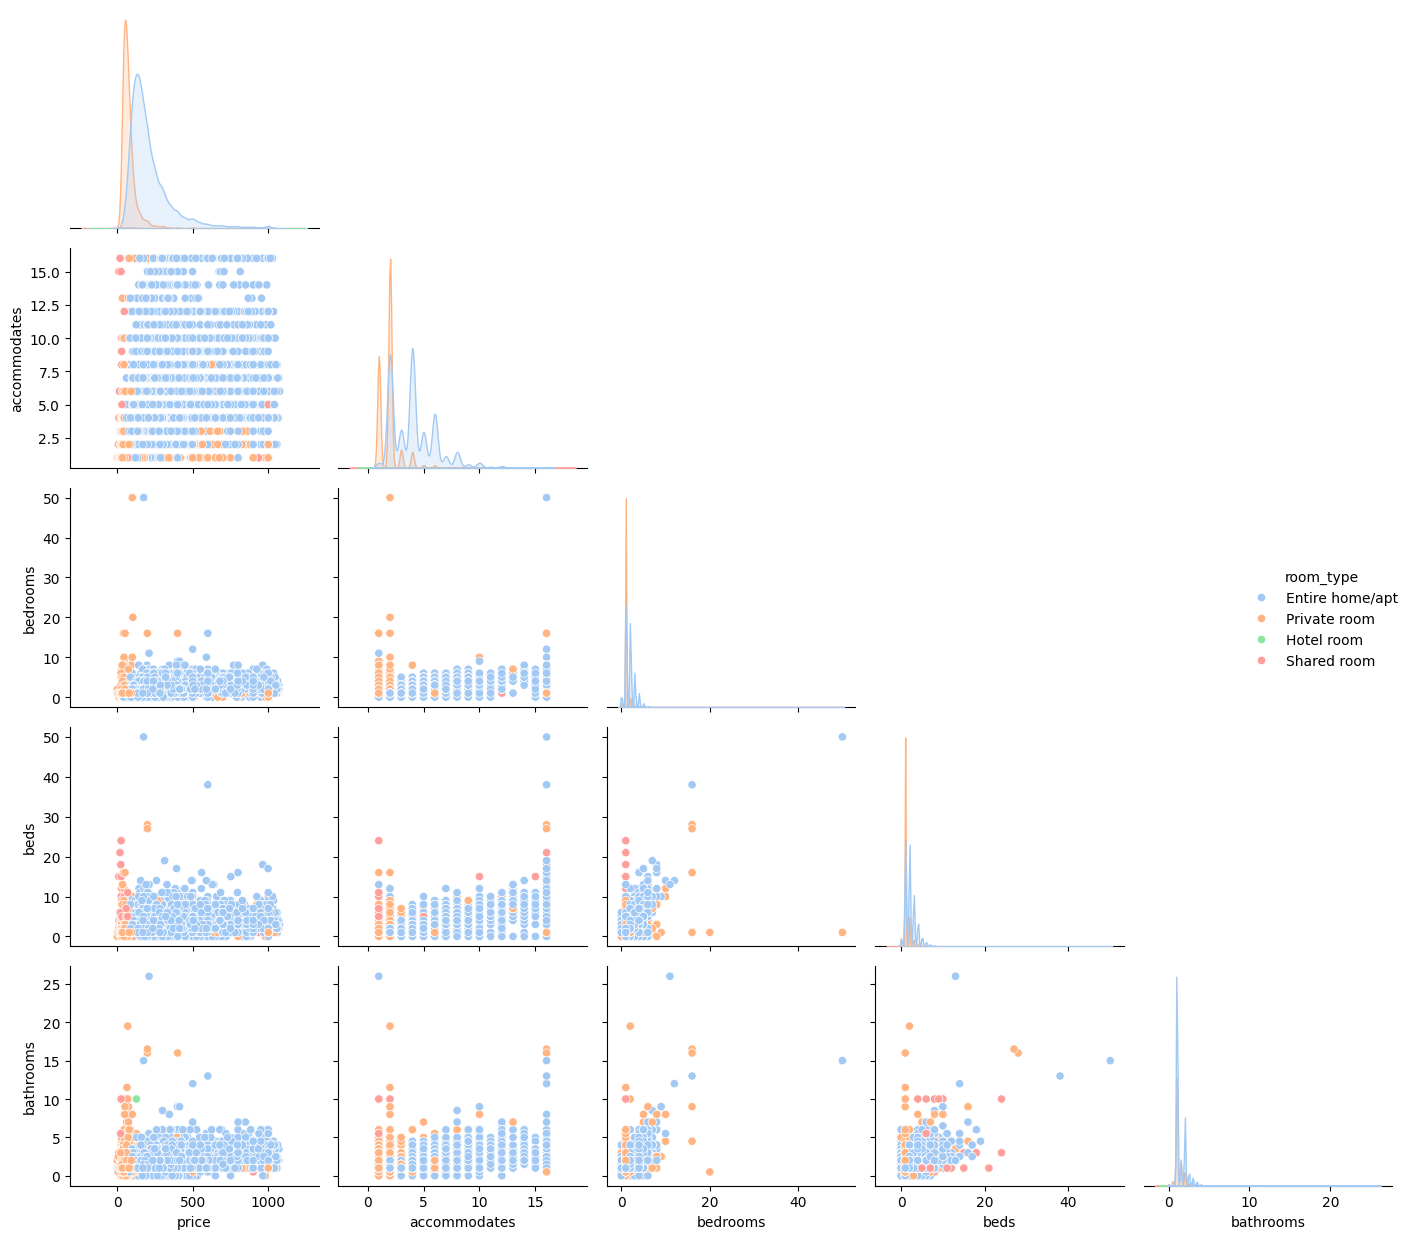

In [10]:
data = df_clean[['price', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'room_type']]
plt.figure(figsize=(10, 8))
sns.pairplot(data, hue='room_type', diag_kind='kde', palette=COLORS, corner=True)

plt.tight_layout()
plt.savefig('figures/analysis/pair_plot.png', dpi=DPI, bbox_inches=BBOX)
plt.show();

---

## Check for Normality

Use multiple tests to numerically test if the price could be normally distributed.

In [11]:
# Shapiro-Wilk Test
stat, p_value = stats.shapiro(df_clean['price'])
print("Shapiro-Wilk Test:")
print("Statistic:", stat)
print("p-value:", p_value)
print("Verdict: ", "Reject Normality" if p_value < 0.05 else "Fail to reject Normality")

# Anderson-Darling Test
result = stats.anderson(df_clean['price'], dist='norm')
print("\nAnderson-Darling Test:")
print("Statistic:", result.statistic)
print("Critical Values:", result.critical_values)
print("Significance Levels:", result.significance_level)
print("Verdict: ", "Reject Normality" if result.statistic > result.critical_values[2] else "Fail to reject Normality")

# D'Agostino and Pearson's Test
stat, p_value = stats.normaltest(df_clean['price'])
print("\nD'Agostino and Pearson's Test:")
print("Statistic:", stat)
print("p-value:", p_value)
print("Verdict: ", "Reject Normality" if p_value < 0.05 else "Fail to reject Normality")

# Kolmogorov-Smirnov Test
stat, p_value = stats.kstest(df_clean['price'], 'norm', args=(df_clean['price'].mean(), df_clean['price'].std()))
print("\nKolmogorov-Smirnov Test:")
print("Statistic:", stat)
print("p-value:", p_value)
print("Verdict: ", "Reject Normality" if p_value < 0.05 else "Fail to reject Normality")

Shapiro-Wilk Test:
Statistic: 0.7621397236917634
p-value: 1.6886009876756556e-125
Verdict:  Reject Normality

Anderson-Darling Test:
Statistic: 3572.5376953069353
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
Verdict:  Reject Normality

D'Agostino and Pearson's Test:
Statistic: 32818.154547731494
p-value: 0.0
Verdict:  Reject Normality

Kolmogorov-Smirnov Test:
Statistic: 0.15910238077073047
p-value: 0.0
Verdict:  Reject Normality


Plot the Q-Q Plot to visualy check for normality.

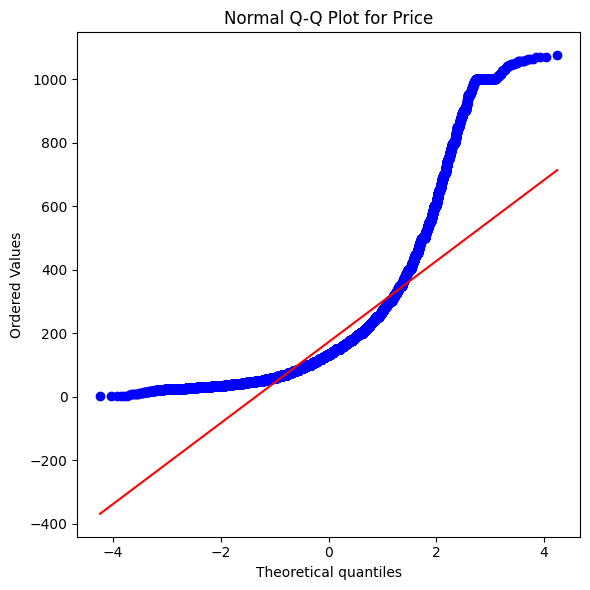

In [12]:
plt.figure(figsize=(6,6))
stats.probplot(df_clean['price'], dist='norm', plot=plt)
plt.title('Normal Q-Q Plot for Price')

plt.tight_layout()
plt.savefig('figures/analysis/normal_qq_plot.png', dpi=DPI, bbox_inches=BBOX)
plt.show();